<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/ESAA_OB_week1_hands_on_classify_p_127~154.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESAA OB 1주차 과제 - 핸즈온 CHAPTER3 분류**

---

## **3.1 MNIST**

>MNIST: 손으로 쓴 70,000개의 작은 숫자 이미지<br/>
각 이미지가 어떤 숫자인지 레이블 존재


In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

>사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있음
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

>* 이미지가 70,000개 있고 각 이미지에는 784개의 특성 존재(28 x 28 픽셀이기 때문)
* 개개의 특성은 단순이 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

>샘플의 특성 벡터를 추출해서 28 x 28 배열로 크기를 바꾸고 matplotlib의 imshow() 함수를 사용해 그리면 데이터셋에서 이미지 확인 가능

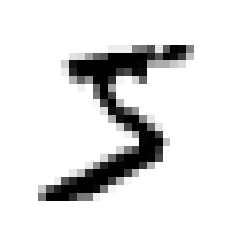

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X.iloc[0].to_numpy()    # 첫 observation 추출 후 np.array로 변형(reshape하기 위함)
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
# 실제 레이블 확인
y[0]

'5'

In [5]:
# 레이블 문자열->정수 변환
y = y.astype(np.uint8)

In [6]:
# 데이터 자세히 조사 전 항상 테스트 세트를 만들어 따로 뗴어놓아야 함.
# MNIST 데이터셋은 훈련세트(앞 60,000개 이미지)와 테스트 세트(뒤쪽 10,000개 이미지)로 이미 나뉘어져있음
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

>* 훈련 세트는 이미 섞여있어서 모든 교차 검증 폴드를 비슷하게 만듦(하나의 폴드라도 특정 숫자가 누락되면 안됨)
* 훈련 샘플의 순서에 민감한 학습 알고리즘도 존재해 비슷한 샘플이 연이어 나타나면 성능이 나빠짐 -> 데이터셋을 섞으면 이런 문제 방지 가능

---

## **3.2 이진 분류기 훈련**

>* 문제 단순화해서 하나의 숫자만 식별해보기(예. 숫자 5)
* 이 '5-감지기'는 **이진 분류기(binary classifier)**(5, 5 아님)

In [7]:
# 분류 작업 위해 타깃 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

>* 분류 모델 하나 선택해 훈련
* **확률적 경사 하강법(SGD)**(Stochastic Gradient Descent) 분류기 이용(SGDClassifer)
* 한 번에 하나씩 훈련 샘플을 독립적으로 처리함 -> 매우 큰 데이터셋을 효율적으로 처리하는 장점.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

* 해당 이미지가 5를 나타낸다고 추측(True)

---

## **3.3 성능 측정**

>* 분류기 평가는 회귀 모델보다 훨씬 어려움

### **3.3.1 교차 검증을 사용한 정확도 측정**

>**교차 검증 구현**
* 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어하고 싶을 때 -> 직접 교차 검증 기능 구현 가능!

In [10]:
# cross_val_score()와 거의 같은 작업 수행하고 동일한 결과 출력
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


>* StratifiedKFold는 클래스별 비율이 유지되도로고 폴드를 만들기 위해 계층적 샘플링을 수행함
* 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
* 이후 올바른 예측의 수를 세어 정확한 예측의 비율 출력함.

---

>cross_val_score()로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가해보기
* k-겹 교차검증은 훈련 세트를 k개(여기서는 3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용함.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

>* 모든 교차 검증 폴드에 대해 정확도가 95% 이상.
* 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보기

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

>정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유
* 정확도가 90% 이상으로 나옴(이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측 시 정확도 90%)
* 불균형한 데이터셋을 다룰 때 특히 심함.


### **3.3.2 오차 행렬**

>오차행렬: 분류기의 성능을 평가하는 더 좋은 방법
* 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것.
* 예) 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수: 오차행렬의 5행 3열

> * 실제 타깃과 비교할 수 있도록 먼저 예측값 생성
* 테스트 세트로 예측값 생성 가능하지만 사용하면 안됨
* (테스트 세트는 분류기가 출시 준비를 마치고 프로젝트의 맨 마지막에 사용됨)
* cross_val_predict() 사용

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

> * cross_val_score()처럼 cross_val_predict()도 k-겹 교차 검증을 수행하지만, 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함
* 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨(모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 뜻)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

> 오차행렬의 행:실제 클래스 / 열:예측한 클래스
* 첫번째 행은 '5 아님' 이미지(**음성 클래스**)에 대한 것, 53892개를 '5 아님'으로 정확하게 분류함(**진짜 음성**)
* 나머지 687개는 '5'라고 잘못 분류함(**거짓 양성**)
* 두번째 행은 '5' 이미지(**양성 클래스**)에 대핸 것, 1891개를 '5 아님'으로 잘못 분류(**거짓 음성**)
* 나머지 3530개는 정확히 '5'라고 분류(**진짜 양성**)

In [16]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

> **정밀도**: 양성 예측의 정확도<br/>
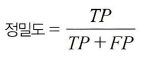<br/>
*TP: 진짜 양성 수 / FP: 거짓 양성 수

> 정밀도는 재현율과 같이 사용하는 것이 일반적
* **재현율**: 분류기가 정확하게 감지한 양성 샘플의 비율
* 민감도 or 진짜 양성 비율(TPR)이라고도 함<br/>
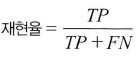<br/>
* FN: 거짓 음성의 수

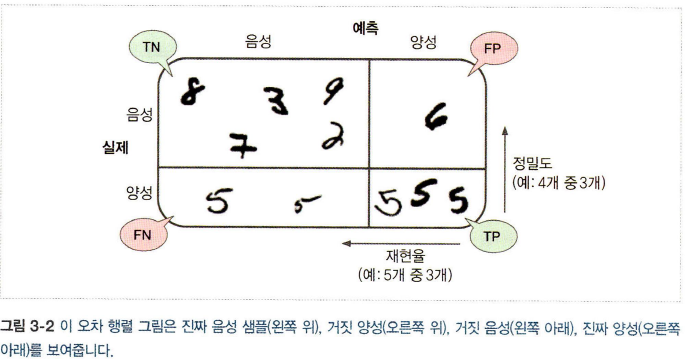

### **3.3.3 정밀도와 재현율**

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

> 5로 판별된 이미지 중 83.7%만 정확함 / 전체 숫자 5에서 65.1%만 감지함

> 정밀도와 재현율을 F1 score라고 하는 하나의 숫자로 만들면 편리함(특히 두 분류기를 비교하는 상황에서 편리)
* **f1 score**: 정밀도와 재현율의 **조화 평균**<br/>
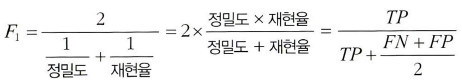

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### **3.3.4 정밀도/재현율 트레이드오프**

>* 정밀도: 양성 예측 중 진짜 양성 비율
* 재현율: 양성 중 양성으로 예측한 비율

> SGDClassifier가 분류를 어떻게 결정하는지를 살펴보며 이해하기
* 이 분류기는 결정 함수(decision function)를 사용하여 각 샘플의 점수 계산
* 이 점수가 임곗값보다 클 경우 샘플을 양성 클래스에 할당하고 그렇지 않을 시 음성 클래스에 할당
* 결정 임곗값을 높이면(오른쪽 화살표로 옮기면): 정밀도 높아지고 재현율 낮아짐
* 결정 임곗값 내리면(왼쪽 화살표로 옮기면): 정밀도 낮아지고 재현율 높아짐<br/>
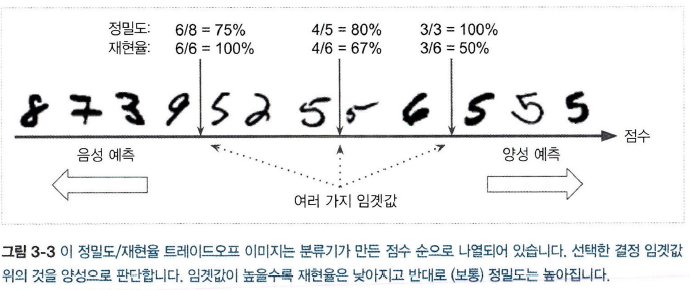

> * 사이킷런에서 임곗값을 직접 지정은 불가하지만 예측에 사용한 점수는 확인 가능
* 분류기의 predict() 메서드 대신 decision_function() 메서드 호출 시 각 샘플의 점수를 얻을 수 있음
* 이 점수를 기반으로 원하는 임곗값 정해 예측 만들 수 있음

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
# 임곗값 높여보기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

> * 이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓치게 됨
* 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌

> 적절한 임곗값은 어떻게 설정할까?
* cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야함(예측 결과가 아닌 결정 점수를 반환하도록 지정)
* 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산 가능

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
import warnings
warnings.filterwarnings('ignore')

#폰트 설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc("font", family = "NanumBarunGothic")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

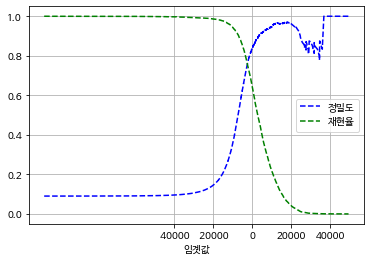

In [25]:
# matplotlib을 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],"b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1],"g--", label="재현율")
  [...] # 임곗값을 표시하고 범례, 축 이름, 그리드 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.grid(True)
plt.xticks([-40000,-20000,0,20000,40000],[f'{x}'.replace('-', '\N{MINUS SIGN}') for x in [-40000,-20000,0,20000,40000]])
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
plt.xlabel('임곗값')
# plt.axvline(8000,0,) 임곗값 표시 어떻게?
plt.legend()
plt.show()

> 좋은 정밀도/재현율 트레이드오프를 선택하는 방법: 재현율에 대한 정밀도 곡선 그리기<br/>
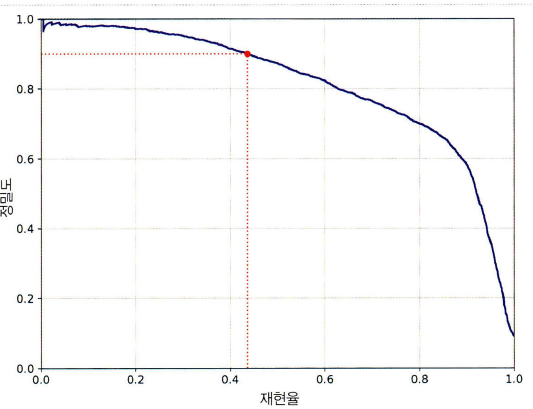

> * 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함
* 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음
* 정밀도 90% 달성이 목표라 할 때, 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] #np.argmax()는 최댓값의 첫번째 인덱스 반환함(여기선 첫번째 True 값 의미)
threshold_90_precision

3370.019499143958

In [27]:
# 예측 생성
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
# 예측에 대한 정밀도, 재현율 확인
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90) 

(0.9000345901072293, 0.4799852425751706)

### **3.3.5 ROC 곡선**

> 수신기 조작 특성(ROC) 곡선
* 이진 분류에서 자주 사용함
* 정밀도/재현율 곡선과 매우 비슷
* **거짓 양성 비율(FPR)**에 대한 **진짜 양성 비율(TPR)(=재현율)**의 곡선
* 거짓 양성 비율(FPR)(양성으로 잘못 분류된 음성 샘플의 비율) = 1 - **진짜 음성 비율(TNR)**(정확하게 분류한 음성 샘플의 비율)
* ROC 곡선은 **민감도**(재현율)에 대한 1-**특이도(TNR)** 그래프라고도 함

In [29]:
# ROC 곡선을 그리기 위해 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

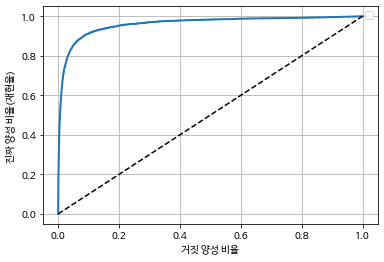

In [30]:
#matplotlib 사용하여 TPR에 대한 FPR 곡선 나타내기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--') #대각 점선
  [...] # 축 이름, 그리드 추가
  plt.xlabel('거짓 양성 비율')
  plt.ylabel('진짜 양성 비율(재현율)')   #진짜 양성 비율은 재현율 아니고 정밀도 아닌가..?
  plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.legend()
plt.show()

> * 모든 가능한 임곗값에서 진짜 양성 비율에 대한 거짓 양성 비율을 나타낸 ROC 곡선.

> * 여기에도 트레이드오프 존재.
* 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
* 점선: 완전한 랜덤 분류기의 ROC 곡선 의미.(좋은 분류기는 이 점선에서 최대한 멀리 떨어져있어야함)
* 곡선 아래의 면적(AUC)을 측정하면 분류기 비교 가능
* 완벽한 분류기의 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> ROC 곡선과 정밀도/재현율(PR) 곡선의 상황별 사용
* 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때: PR 곡선 사용 / 그렇지 않으면 ROC 곡선 사용
* PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여줌.

> RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수 비교해보기
* 먼저 훈련세트의 샘플에 대한 점수를 얻어야 함.
* RandomForestClassifier에는 decision_function() 메서드가 없고 predict_proba() 메서드가 있음
* predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 확률을 반환함.

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
#roc_curve() 함수는 레이블과 점수를 기대함. 하지만 점수 대신 클래스 확률 전달 가능.
# 양성 클래스 확률을 점수로 사용하기
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

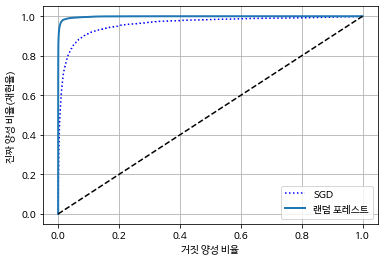

In [35]:
# ROC 곡선 그리기 -비교를 위해 첫번째 ROC 곡선도 함께 그림
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

>랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음(랜덤포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 AUC 값이 크기 때문)
* ROC AUC 점수도 당연히 훨씬 높음

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

> **정리**
* 이진 분류기를 훈련시키는 방법
* 작업에 맞는 적절한 지표 선택
* 교차 검증을 사용한 평가
* 요구 사항에 맞는 정밀도/재현율 트레이드오프 선택
* ROC 곡선과 ROC AUC 점수를 사용한 여러 모델의 비교

---

## **3.4 다중 분류**

>* **다중 분류기(=다항 분류기)** : 둘 이상의 클래스 구별 가능
* SGD 분류기, 랜덤포레스트 분류기, 나이브 베이즈 분류기와 같은 일부 알고리즘은 여러개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 분류기와 같은 다른 알고리즘은 이진 분류만 가능

> **OvR(one-versus-the-rest) 전략**
* 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.
*예) 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 생성 가능
* 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택하면 됨
* 이를 **OvR**(one-versus-the-rest) 전략 또는 OvA(one-versus-all) 전략이라 부름

> **OvO(one-versus-one) 전략**
* 또 다른 전략은 0과 1 구별, 0과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것: **OvO**(one-versus-one) 전략
* 클래스가 n개면 분류기는 n x (n-1)/2 개 필요함
* 이미지 하나를 분류하려면 이 분류기 모두를 통과시켜 가장 많이 양성으로 분류된 클래스 선택.
* OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것.

>* 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 OvO 선호
* 하지만 대부분의 이진 분류 알고리즘에서는 OvR 선호

In [37]:
# 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷렁니 알고리즘에 따라 자동으로 OvR 또는 OvO 실행
#서포트 벡터 머신 분류기 테스트해보기
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  #y_train_5가 아니고 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

>* 5를 구별한 타깃 클래스(y_train_5) 대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 SVC 훈련시킴
* 이후 예측 하나를 만듦(5인 것을 맞춤)
* 내부에서는 사이킷런의 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택함.->정말 그런지 확인!

In [38]:
# decision_function() 메서드를 호출하면 (1개가 아니라) 샘플 당 10개의 점수를 반환함(클래스마다 하나씩)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [42]:
np.argmax(some_digit_scores), svm_clf.classes_, svm_clf.classes_[5]

(5, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 5)

>* 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용

In [44]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만드는 예시 코드
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit]), len(ovr_clf.estimators_)

(array([5], dtype=uint8), 10)

In [47]:
# SGDClassifier(또는 RandomForestClassifier)를 훈련시키는 것도 간단함
# SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도의 사이킷런의 OvR이나 OvO를 적용할 필요 없음
# decision_function() 메서드는 클래스마다 하나의 값 반환
# SGDD 분류기가 클래스마다 부여한 점수 확인해보기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]), sgd_clf.decision_function([some_digit])

(array([3], dtype=uint8),
 array([[-31893.03095419, -34419.69069632,  -9530.63950739,
           1823.73154031, -22320.14822878,  -1385.80478895,
         -26188.91070951, -16147.51323997,  -4604.35491274,
         -12050.767298  ]]))

>* 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음(클래스 3은 조금 의심하고 있음)

>* 분류기 평가 - 일반적으로 교차 검증 사용

In [48]:
# cross_val_score() 함수 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

> 점수가 나쁘지 않지만 성능 높일 여지 있음

In [51]:
# 간단하게 입력의 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## **3.5 에러 분석**

> 실제 프로젝트라면 머신러닝 프로젝트 체크리스트(부록 B)의 단계를 따를 것.
* 데이터 준비 단계에서 가능한 선택 사항 탐색
* 여러 모델 시도
* 가장 좋은 몇개를 골라 GridSearchCV를 사용해 하이퍼파라미터를 세밀하게 튜닝
* 가능한 한 자동화

>이 절에서는 가능성이 높은 모델을 하나 찾았다 가정하고 모델 성능 향상 방법 찾기
* 한 가지 방법은 에러의 종류를 분석하는 것 - 오차행렬

In [53]:
# cross_val_predict() 함수를 사용해 예측을 만들고 이전처럼 confusion_matrix() 함수 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

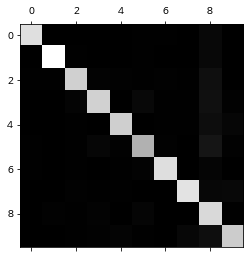

In [54]:
# 오차행렬은 matplotlib의 matshow() 함수를 사용해 이미지로 표현하면 보기 편리할 때 많음
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

> 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 좋아보임
* 숫자 5는 다른 숫자보다 어두워보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 듯(두 경우 모두 확인해봐야함)

>* 그래프의 에러 부분에 초점.
* 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어(에러의 절대 개수가 아니라) 에러 비율을 비교.

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

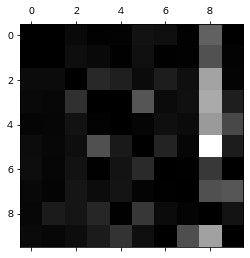

In [58]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

> 여기서 분류기가 만든 에러를 확실히 볼 수 있음
* 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다는 사실 기억.
* 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시
* 하지만 클래스 8의 행은 나쁘지 않음-> 실제 8은 적절히 8로 분류됨
* 이렇듯 오차행렬은 반드시 대칭인 것은 아님
* 3과 5 서로 많이 혼동됨을 볼 수 있음

> 오차행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음
* 이 그래프를 살펴보면 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있음
* 예를 들어 8처럼 보이는 다른 숫자드릐 후련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있음
* 또는 분류기에 도움될 만한 특성을 더 찾아볼 수 있음
* 예를 들어 동심원의 수를 세는 알고리즘(8은 2개, 6은 1개, 5는 0개)
* 또는 동심원 같은 어떤 패턴이 드러나도록(Scikit-Image, Pillow, OpenCV 등 사용) 이미지 전처리 가능

>개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못 분류되었는지에 대해 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래걸림
* 예를 들어 3과 5의 샘플 그려보기
* plot_digits()는 단순히 matplotlib의 imshow() 함수를 사용하는 함수

In [79]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

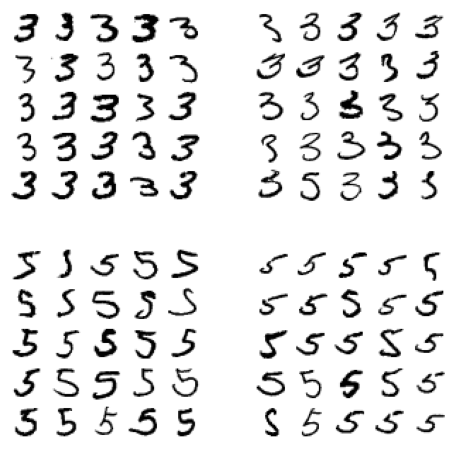

In [80]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

>* 왼쪽의 5 x 5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5 x 5 블록 2개는 5로 분류된 이미지.
* 대부분의 잘못 부류된 이미지는 확실히 에러. 분류기가 실수한 이유를 이해하기 어려움
* 원인은 선형 모델인 SGDClassifier를 사용했기 떄문
* 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산
* 따라서 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

> * 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
* 숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우치면 분류기가 5로 분류하고, 반대도 마찬가지
* 즉, 분류기는 이미지의 위치나 회전 방향에 매우 민감함
* 3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어있지 않도록 전처리하는 것

## **3.6 다중 레이블 분류**

> **다중 레이블 분류 시스템** : 여러 개의 이진 꼬리표를 출력하는 분류 시스템
* 지금까지는 각 샘플이 하나의 클래스에만 할당되었음.
* 하지만 분류기가 샘플마다 여러개의 클래스를 출력해야할 때도 있음
* 예를 들어, 얼굴 인식 분류기는 같은 사진에 여러 사람이 등장한다면, 인식된 사람마다 하나씩 꼬리표(tag)를 붙여야함.
* 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정
* 앨리스와 찰리가 있는 사진을 본다면 [1,0,1]을 출력해야함(앨리스 있음, 밥 없음, 찰리 있음)

In [81]:
# 더 간단한 예 살펴보기
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

>* 이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦
* KNeighborClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킴(KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그렇지는 않음)

In [82]:
# 예측
knn_clf.predict([some_digit])

array([[False,  True]])

> 숫자 5는 크지 않고(False) 홀수(True)임 -> 올바르게 분류됨

> 다중 레이블 분류기를 평가하는 방법은 많음
* 적절한 지표는 프로젝트에 따라 다름

---

## **3.7 다중 출력 분류**

> **다중 출력 다중 클래스 분류(다중 출력 분류)** : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(즉, 값을 두 개 이상 가질 수 있음)
* 이를 위해 이미지에서 잡음을 제거하는 시스템 생성
* 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
* 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0~255 픽셀 강도)
* 그러므로 이 예는 다중 출력 분류 시스템

>* 이 예에서처럼 분류와 회귀 사이의 경계는 때때로 모호함.
* 픽셀 강도 예측은 분류보다 회귀와 비슷함
* 다중 출력 시스템은 더욱이 분류 작업에 국한되지도 않음
* 따라서 샘플마다 클래스와 값을 모두 포함하는 다중 레이블이 출력되는 시스템도 가능함

> * 먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수를 사용하여 픽셀 강도에 잡음 추가
* 타깃 이미지는 원본 이미지가 될 것

In [84]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

>* 테스트 세트에서 이미지를 하나 선택(원래 테스트 데이터를 들여다보는 것은 안됨!)<br/>
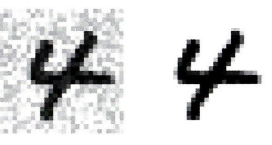
* 왼쪽이 잡음이 섞인 입력 이미지이고 오른쪽이 깨끗한 타깃 이미지
* 분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보기

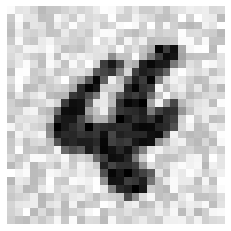

In [109]:
# 테스트 세트에서 이미지 하나 선택
some_digit = X_test_mod.iloc[95].to_numpy()
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

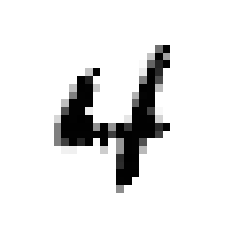

In [110]:
# 분류기를 훈련시켜 이미지 깨끗하게 만듦
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[95].to_numpy()])
plot_digits(clean_digit)

> 타깃과 매우 비슷해짐